# Podcast Analysis

I performed an exploratory analysis of the scrapped podcast data. 

* I found no obvious linear relationship or strong correlation between different columns.
* I then converted "GenreIDs" into features, and tried to predict the ratings with a Random Forest Regressor
* While the regressor produced small errors, a similar error is created when target data is shuffled. This means that the model failed to capture relationships in the data, and is just performing well by chance. Perhaps more information is needed, or the data is too skewed towards higher ratings. 

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
podcastdf = pd.read_csv('df_popular_podcasts.csv')
podcastdf.head(2)

,Item,ID,Artwork,Genre IDs,Episode Count,iTunes URL,Feed URL,Avg Rating,Rating Count,Description
0,Frankie B's Reggae Session,545234281,https://is1-ssl.mzstatic.com/image/thumb/Podca...,"['1525', '26', '1310']",70,https://podcasts.apple.com/us/podcast/frankie-...,https://frankiebsession.podbean.com/feed.xml,4.8,28,Frankie B's Reggae Session Podcast takes Color...
1,Rotoworld Football Podcast,1089780289,https://is2-ssl.mzstatic.com/image/thumb/Podca...,"['1547', '26', '1545']",328,https://podcasts.apple.com/us/podcast/rotoworl...,https://rss.art19.com/rotoworld-football,4.7,690,From fantasy implications to NFL draft analysi...


In [4]:
# convert the 'Genre ID' column to numbers. 
# note that the ID '26' means 'podcast' and is present in all rows and is thus redundant and removed.  
GenreIDs = [i.split('\'')[1::2] for i in podcastdf['Genre IDs']]
GenreIDs = [list(map(int, i)) for i in GenreIDs]
for i in GenreIDs:
    i.remove(26)

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]
GenreIDs_flat = np.asarray(flatten(GenreIDs))
unique_GenreIDs = np.unique(GenreIDs_flat)
print('There are ' + str(len(np.unique(GenreIDs_flat))) + ' unique GenreIDs.')

There are 110 unique GenreIDs.


In [6]:
# Create a DataFrame to convert GenreIDs into indicator variables. 
GenreIDs_df = pd.DataFrame(np.zeros((len(GenreIDs),len(np.unique(GenreIDs_flat)))),columns=unique_GenreIDs)
for n,i in enumerate(GenreIDs):
    for j in i:
        idx = np.argwhere(unique_GenreIDs == j)
        GenreIDs_df.iloc[n,idx]=1

In [7]:
# keep the revelant columns of poddf and merge it with GenreIDs_df
columns = ['ID','Episode Count', 'Avg Rating', 'Rating Count','Description']
poddf = podcastdf[columns]
poddf = poddf.merge(GenreIDs_df,left_index =True,right_index=True)
poddf.head(2)

,ID,Episode Count,Avg Rating,Rating Count,Description,1301,1302,1303,1304,1305,...,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565
0,545234281,70,4.8,28,Frankie B's Reggae Session Podcast takes Color...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1089780289,328,4.7,690,From fantasy implications to NFL draft analysi...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


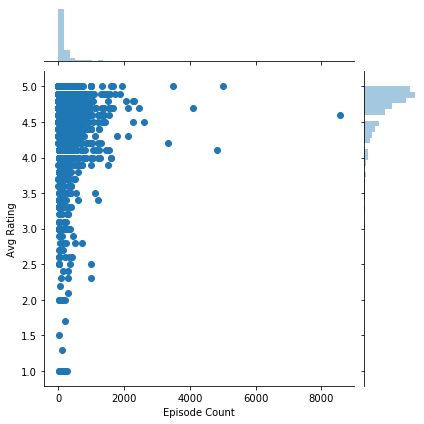

In [8]:
# explore if podcasts have more episodes would have better ratings.  
sns.jointplot('Episode Count','Avg Rating', data=poddf)
# comments: ratings are sckewed towards 5 stars. 
# most podcasts have less than 2000 episode counts. Thus plotting the x-axis on a log scale next. 

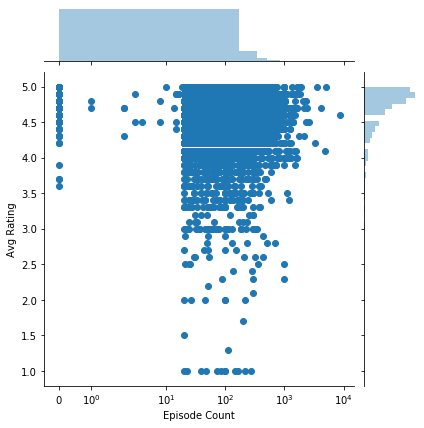

In [9]:
g=sns.jointplot('Episode Count','Avg Rating', data=poddf)
g.ax_joint.set_xscale('symlog')
# Comments: the average rating of a podcasts doesn't seem to correlate strongly with the number of episodes. 
# The podcasts in this dataset is skewed towards better ratings. 

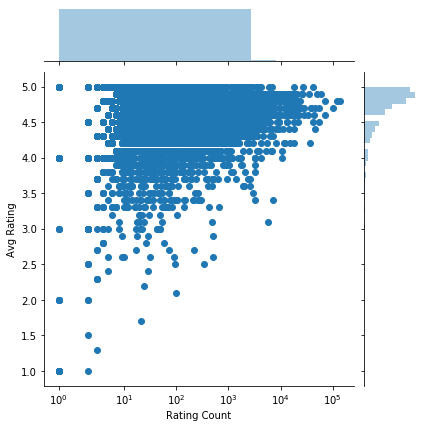

In [10]:
# explore if podcasts have more ratings would have higher average ratings. 

# plotting rating count on a log scale. 
g= sns.jointplot('Rating Count','Avg Rating', data=poddf)
g.ax_joint.set_xscale('symlog')
# Comments: interestingly, the plot seems to have the lower triangle cut off. 
# This implies while podcasts with less ratings could have high average rating, podcasts with lots of ratings can't have a low average!

C:\Users\Huayi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


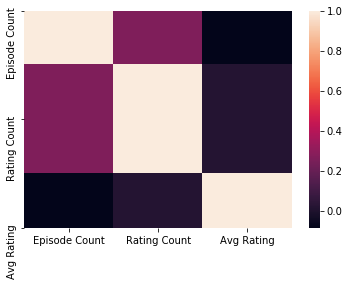

In [11]:
# examine correlation between 'Avg Rating' and log values of 'Episode Count'& 'Rating Count' 
poddf[['Episode Count','Rating Count']] = np.log(poddf[['Episode Count','Rating Count']])
poddf.replace([np.inf, -np.inf], 0, inplace=True)
sns.heatmap(poddf[['Episode Count','Rating Count','Avg Rating']].corr())
# Comments: Rating Count is weakly correlated with Episode Count. 
# There's a weaker correlation between Rating Count and Ave Rating.  

In [12]:
poddf.head(2)

,ID,Episode Count,Avg Rating,Rating Count,Description,1301,1302,1303,1304,1305,...,1556,1557,1558,1559,1560,1561,1562,1563,1564,1565
0,545234281,4.248495,4.8,3.332205,Frankie B's Reggae Session Podcast takes Color...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1089780289,5.793014,4.7,6.536692,From fantasy implications to NFL draft analysi...,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# As the data seems to have nonlinear relationship, I used the "decision tree regressor" to predict ratings. 
from sklearn.model_selection import train_test_split
X = poddf.drop(columns=['ID','Avg Rating','Description'])
Y = poddf['Avg Rating']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=61)

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

regr_1 = RandomForestRegressor(max_depth=2)
regr_2 = RandomForestRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# calculate error
print('error for regressor 1 is ' + str(np.sqrt(mean_squared_error(y_1, y_test))))
print('error for regressor 2 is ' + str(np.sqrt(mean_squared_error(y_2, y_test))))

error for regressor 1 is 0.3359860546398286
error for regressor 2 is 0.3342249148494159


In [15]:
print("Features sorted by their score for regressor 1:")
print(sorted(zip(map(lambda x: round(x, 4), regr_1.feature_importances_[regr_1.feature_importances_!=0]),
                 X_train.columns[regr_1.feature_importances_!=0]),reverse=True))

print("\nFeatures sorted by their score for regressor 2:")
print(sorted(zip(map(lambda x: round(x, 4), regr_2.feature_importances_[regr_2.feature_importances_!=0]),
                 X_train.columns[regr_2.feature_importances_!=0]),reverse=True))



Features sorted by their score for regressor 1:
[(0.3494, 'Episode Count'), (0.2909, 1562), (0.1715, 'Rating Count'), (0.1363, 1498), (0.0451, 1519), (0.0068, 1561)]

Features sorted by their score for regressor 2:
[(0.2316, 'Episode Count'), (0.1979, 'Rating Count'), (0.1083, 1562), (0.0766, 1498), (0.0333, 1495), (0.0283, 1532), (0.0261, 1528), (0.0236, 1516), (0.0235, 1531), (0.022, 1509), (0.0211, 1412), (0.0179, 1490), (0.0177, 1305), (0.0169, 1561), (0.0139, 1483), (0.0138, 1519), (0.013, 1551), (0.0129, 1520), (0.0113, 1501), (0.0105, 1484), (0.0101, 1482), (0.0094, 1489), (0.0082, 1314), (0.0075, 1309), (0.0067, 1524), (0.0063, 1548), (0.0053, 1303), (0.0045, 1488), (0.0035, 1563), (0.0033, 1526), (0.0032, 1505), (0.0026, 1533), (0.0019, 1492), (0.0016, 1494), (0.0014, 1500), (0.0011, 1306), (0.001, 1406), (0.0009, 1487), (0.0005, 1324), (0.0004, 1544), (0.0004, 1320), (0.0, 1496)]


In [16]:
# note that the Genre with ID #1562 pops out in both regressors. 
# Here I explore if this Genre is quantitatively special
poddf[1562].sum()

217.0

Text(0.5, 0.98, 'Distribution of Avg. Rating for GenreID 1562')

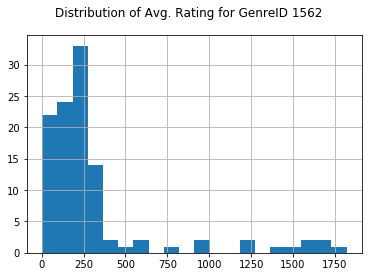

In [17]:
GenreIDs_df.sum().hist(bins=20)
plt.suptitle("Distribution of Avg. Rating for GenreID 1562")
# The Genre #1562 has 217 podcasts. As shown in the histogram below, this number is fairly common. 

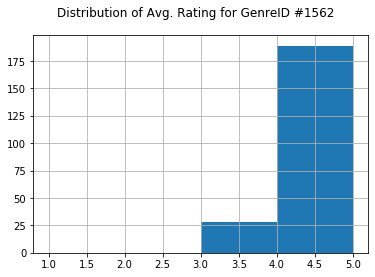

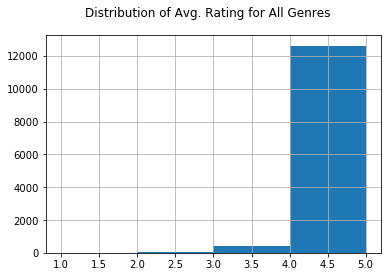

In [18]:
# Comparing the two graphs below, the distribution of ratings for Genre # 1562 is also not drastically different from the whole dataset. 
# One interpretation is that the Genre #1562 may not be quantitatively special but qualitatively special.
# #1562 refers to the genre "After Shows". It may be interesting to explore why this genre is a more important feature. 
poddf['Avg Rating'][poddf[1562]==1].hist(bins=[1,2,3,4,5])
plt.suptitle("Distribution of Avg. Rating for GenreID #1562")
plt.show()
poddf['Avg Rating'].hist(bins=[1,2,3,4,5])
plt.suptitle("Distribution of Avg. Rating for All Genres")
plt.show()

In [22]:
# both regressors generated small errors. However, the model could achieve this by chance, 
# esp. that the data is skewed towards higher ratings.
# Here, I shuffle the y_train data and repeat the model fitting, prediction and error calculation.
# I repeat this process 1000 times to get the averaged error

errors = 0; n=0
while n !=1000:
    y_train_shuffled = y_train.sample(frac=1).reset_index(drop=True)
    regr_verify = RandomForestRegressor(max_depth=4)
    regr_verify.fit(X_train,y_train_shuffled)
    y_verfiy = regr_verify.predict(X_test)
    # calculate error
    errors +=np.sqrt(mean_squared_error(y_verfiy, y_test))
    n +=1
error = errors/1000                  


In [23]:
print('The new error is ',error)
# note that this error is very comparable to the error generated before. 
# Thus, the model isn't really capturing unique data relationships  

The new error is  0.3404992540940464


# Summary:
The "random forest regressor" method appeared to work well as errors are small. However, shuffling training targets generated similar performance. Thus, the model isn't really capturing unique data relationships and could be performing well just by chance. 
## Feature importance: 
 - 'Episode Count' could be an important feature as it pops out for both regressor 1&2.
 - The genre #1562, which corresponds to 'After Shows', could also be important, but its score is much less for regressor 2. As this genre doesn't seem to be quantitatively different from the whole dataset, it could be interesting to explore its qualitative importance. 
 - It's hard to say much about other features that are only present in regressor 2. 